In [1]:
# Supress Warning and import used libs
import warnings
import datetime
import matplotlib.pyplot as plt
import numpy as np
import gc

from utils.utils import (
        lat_lon_to_epsg,
        three_band_image,
        load_config_extents,
        transform_to_wgs)

warnings.filterwarnings('ignore')

In [2]:
# Import data loader

from utils.data_cube_utilities.loader import load_data
from utils.data_cube_utilities.loader import progress_cbk

In [3]:
# Define available spectral indices

def NDVI(dataset):
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

def EVI(dataset):
    return 2.5 * (dataset.nir - dataset.red)/(dataset.nir + 6.0 * dataset.red - 7.5 * dataset.blue + 1.0)

In [4]:
# Define available mosaic creation functions

def median_mosaic(dataset):
    from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
    return create_median_mosaic(dataset)

def mean_mosaic(dataset):
    from utils.data_cube_utilities.dc_mosaic import create_mean_mosaic
    return create_mean_mosaic(dataset)

def max_ndvi(dataset):
    from utils.data_cube_utilities.dc_mosaic import create_max_ndvi_mosaic
    return create_max_ndvi_mosaic(dataset)

def most_recent(dataset):
    from utils.data_cube_utilities.dc_mosaic import create_mosaic
    return create_mosaic(dataset)

In [5]:
# Comparative plotter that plots two images, a baseline and an analysis image.

def plotter(baseline, analysis):
    from utils.utils import three_band_image
    from matplotlib import pyplot as plt

    baseline_img = three_band_image(baseline, bands=['red', 'green', 'blue'])
    analysis_img = three_band_image(analysis, bands=['red', 'green', 'blue'])
    fig = plt.figure(1, [10, 20])

    plt.subplot(211)
    ax = plt.gca()
    ax.set_title("Baseline", fontweight='bold', fontsize=16)
    ax.set_xticklabels(baseline.x.values)
    ax.set_yticklabels(baseline.y.values)
    ax.set_xlabel('Easting', fontweight='bold')
    ax.set_ylabel('Northing', fontweight='bold')

    plt.imshow(baseline_img)

    plt.subplot(212)
    ax = plt.gca()
    ax.set_title("Analysis", fontweight='bold', fontsize=16)
    ax.set_xticklabels(analysis.x.values)
    ax.set_yticklabels(analysis.y.values)
    ax.set_xlabel('Easting', fontweight='bold')
    ax.set_ylabel('Northing', fontweight='bold')
    plt.imshow(analysis_img)

In [6]:
# Parameter checking & Input validation

def check_params(latitude, longitude, time_extents_b, time_extents_a, mosaic_type, spectral):
    if any(lat < -90 or lat > 90 for lat in latitude) or any(lon < -180 or lon > 180 for lon in longitude):
        raise ValueError("Invalid latitude or longitude.")

    time_extents_b = (datetime.datetime.strptime(time_extents_b[0], "%Y-%m-%d"),
                    datetime.datetime.strptime(time_extents_b[1], "%Y-%m-%d"))

    if time_extents_b[0] < datetime.datetime.strptime("2013-01-01", "%Y-%m-%d"):
        raise ValueError("Invalid time extents for baseline.")
    if time_extents_b[1] < datetime.datetime.strptime("2013-01-01", "%Y-%m-%d"):
        raise ValueError("Invalid time extents for baseline.")
    if time_extents_b[0] > time_extents_b[1]:
        raise ValueError("Invalid time extents for baseline.")

    time_extents_a = (datetime.datetime.strptime(time_extents_a[0], "%Y-%m-%d"),
                    datetime.datetime.strptime(time_extents_a[1], "%Y-%m-%d"))

    if time_extents_a[0] < datetime.datetime.strptime("2013-01-01", "%Y-%m-%d"):
        raise ValueError("Invalid time extents for analysis.")
    if time_extents_a[1] < datetime.datetime.strptime("2013-01-01", "%Y-%m-%d"):
        raise ValueError("Invalid time extents for analysis.")
    if time_extents_a[0] > time_extents_a[1]:
        raise ValueError("Invalid time extents for analysis.")

    if mosaic_type not in ["median", "mean", "maxndvi", "recent"]:
        raise ValueError("Invalid mosaic type.")

    if spectral not in ["ndvi", "evi"]:
        raise ValueError("Invalid spectral index.")

### latitude: List of two float numbers represeting the latitude extents. Ex [45.10, 45.25]

### latitude: List of two float numbers represeting the longitude extents. Ex [22.10, 22.25]

### time_extents_b: Tuple of two strings representing the time extents for the baseline.
    Ex ('2013-05-01', '2013-12-01')

### time_extents_a: Tuple of two strings representing the time extents for the analysis period.
    Ex ('2019-05-01', '2019-12-01')

### mosaic_type: String representing the type of mosaic that should be used when creating a cloud-free image.
    This should be one of:
        - "median"
        - "mean"
        - "maxndvi"
        - "recent"

### spectral: String representing the spectral index that should be used to analyze the DOI.
    This can be one of:
        - "ndvi"
        - "evi"
                
### max_cloud: Float representing the maximum percentage of clouded pixels.

In [7]:
# You can change the DOI and algorithm settings here

latitude = [47.25,47.14]
longitude = [25.42,25.69]
time_extents_b = ("2013-05-01","2013-12-01")
time_extents_a = ("2019-05-01","2019-12-01")
mosaic_type = "median"
spectral = "evi"
max_cloud = 0.05

In [8]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude = latitude, longitude = longitude)

In [9]:
try:
    check_params(latitude, longitude, time_extents_b, time_extents_a, mosaic_type, spectral)
except ValueError as e:
    print(e.__str__())

product = "ls8_usgs_level1_scene"
platform = "LANDSAT_8"
EPSG = lat_lon_to_epsg(latitude[1], longitude[1])
output_crs = 'EPSG:' + EPSG
resolution = (-30, 30)

In [10]:
# Load the data
time_extents = time_extents_a
analysis = load_data(
    latitude=latitude,
    longitude=longitude,
    platform=platform,
    time=time_extents,
    product=product,
    output_crs=output_crs,
    resolution=resolution,
    progress_cbk=progress_cbk,
    max_cloud=max_cloud,
    measurements=(
        'red',
        'blue',
        'green',
        'nir',
        'quality'
    )
)

time_extents = time_extents_b
baseline = load_data(
    latitude=latitude,
    longitude=longitude,
    platform=platform,
    time=time_extents,
    product=product,
    output_crs=output_crs,
    resolution=resolution,
    progress_cbk=progress_cbk,
    max_cloud=max_cloud,
    measurements=(
        'red',
        'blue',
        'green',
        'nir',
        'quality'
    )
)


([2019, 5, 1], [2019, 6, 1])
([2019, 6, 1], [2019, 7, 1])


/env/lib/python3.6/site-packages/datacube/storage/masking.py:4: DeprecationWarning: datacube.storage.masking has moved to datacube.utils.masking
  category=DeprecationWarning)


([2019, 7, 1], [2019, 8, 1])
([2019, 8, 1], [2019, 9, 1])
Cloud coverage is under 0.05%, stopping early.
([2013, 5, 1], [2013, 6, 1])
([2013, 6, 1], [2013, 7, 1])
([2013, 7, 1], [2013, 8, 1])
([2013, 8, 1], [2013, 9, 1])
Cloud coverage is under 0.05%, stopping early.


In [11]:
# Mask creating  & Pixel Filtering
from datacube.storage import masking  # Import masking capabilities

# Create mask around all pixels deemed good according to parameters around cloud cover and saturation.
clean_pixel_mask_baseline = masking.make_mask(
    baseline.quality,
    cloud=False,
    radiometric_saturation='none',
    terrain_occlusion=False)

masked_cloud_baseline = baseline.where((baseline != 0) & clean_pixel_mask_baseline)

# We don't need the original datasets now, we only need the masked datasets, so we can free some memory.
# Delaying this step may result in OOM errors.
del(baseline)
gc.collect()

# Create mask around all pixels deemed good according to parameters around cloud cover and saturation.
clean_pixel_mask_analysis = masking.make_mask(
    analysis.quality,
    cloud=False,
    radiometric_saturation='none',
    terrain_occlusion=False)

masked_cloud_analysis = analysis.where((analysis != 0) & clean_pixel_mask_analysis)

# We don't need the original datasets now, we only need the masked datasets, so we can free some memory.
# Delaying this step may result in OOM errors.
del(analysis)
gc.collect()

0

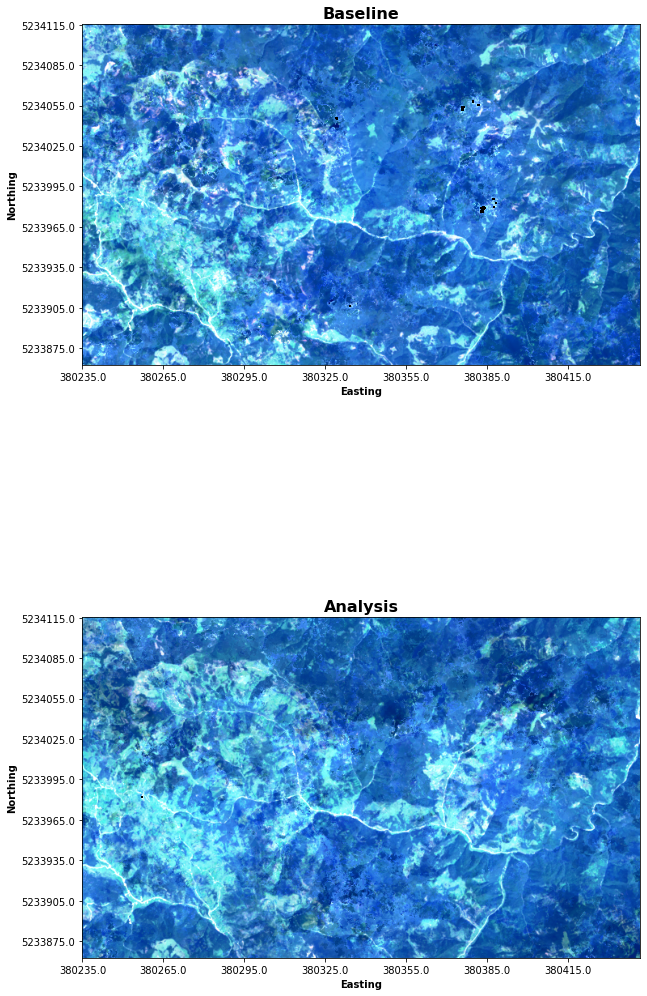

In [12]:
# Mosaic Creation
mosaic = {"median": median_mosaic, "mean": mean_mosaic, "maxndvi": max_ndvi, "recent": most_recent}
baseline_mosaic = mosaic[mosaic_type](masked_cloud_baseline)
analysis_mosaic = mosaic[mosaic_type](masked_cloud_analysis)

baseline_mosaic = baseline_mosaic.expand_dims({"time":1})
analysis_mosaic = analysis_mosaic.expand_dims({"time":1})


plotter(baseline_mosaic, analysis_mosaic)


In [13]:
# Compute spectral indices
index = {"ndvi": NDVI, "evi": EVI}
baseline_index = index[spectral](baseline_mosaic)
analysis_index = index[spectral](analysis_mosaic)

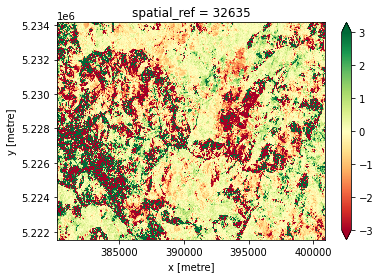

In [14]:
index_change = analysis_index - baseline_index
plt.figure()
index_change.plot(cmap="RdYlGn", vmin=-3.0, vmax=3.0)

In [15]:
# Create a threshold plot using the MIN and MAX range defined above

from matplotlib.ticker import FuncFormatter

def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])

    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.y) * (fixed_width / len(ds.x))
        return (width, height)


    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(da.y.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(da.x.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(array, *args, **kwargs)
    plt.show()

In [16]:
no_data_mask = np.logical_or(np.isnan(baseline_mosaic.isel(time=0).red.values),
                             np.isnan(analysis_mosaic.isel(time=0).red.values)) 

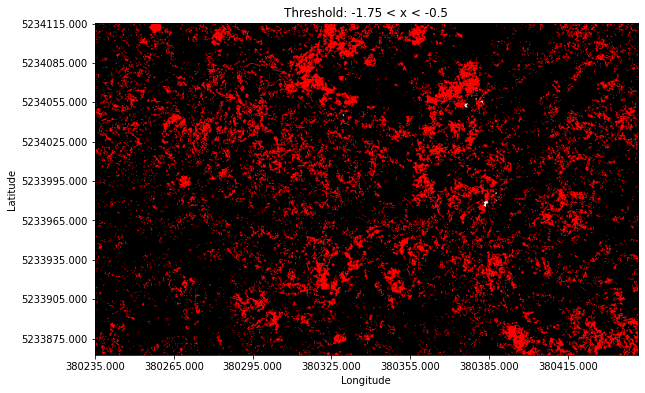

In [17]:
threshold = {"ndvi": (-0.7, -0.2), "evi": (-1.75, -0.5)}

threshold_plot(index_change.isel(time=0), threshold[spectral][0], threshold[spectral][1], mask = no_data_mask, width  = 10)